## Run the program and collect outputs

In [39]:
algos = ["qsort", "stdsort"]

In [40]:
!g++ --version

Configured with: --prefix=/Library/Developer/CommandLineTools/usr --with-gxx-include-dir=/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/4.2.1
Apple clang version 11.0.0 (clang-1100.0.33.8)
Target: x86_64-apple-darwin19.0.0
Thread model: posix
InstalledDir: /Library/Developer/CommandLineTools/usr/bin


In [41]:
!make

make: `main' is up to date.


In [42]:
xyss = {}
for algo in algos:
    output = !./main $algo
    xys = [tuple(l.split()) for l in output ]
    xs = [float(x) for x, _ in xys]
    ys = [float(y) for _, y in xys]
    xyss[algo] = (xs, ys)

## Plot time spent for different sizes of input

In [43]:
import matplotlib.pyplot as plt

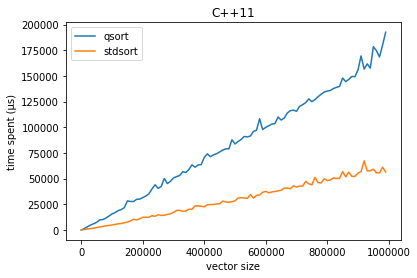

In [44]:
plt.title("C++11")
plt.xlabel("vector size")
plt.ylabel("time spent (μs)")

for algo in algos:
    xs, ys = xyss[algo]
    plt.plot(xs, ys, label=algo)

plt.legend()
plt.show()